__<h1>LOGISTIC REGRESSION & RANDOM FOREST</h1>__

___KEY NOTES IN VERSION 3___
- in this notebook, we aim to determine if the home team wins, 1, or doesn't 0. (loss or draw)
- I used the random forest and logistic regression classification models with default parameters
- performance evaluated with k-fold cv
- outliers removed

In [1]:
import pandas as pd, numpy as np, seaborn as sns, glob, time, os, matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('/Users/ERIA/Desktop/MATCH_DATA/')

The cell below shows how the glob module is used to gather file names of the same type into a list. In this case, I collected all csv files in the /Users/ERIA/Desktop/MATCH_DATA/ directory

In [3]:
csv_files=glob.glob('*.csv')
len(csv_files)

30

all the files are then concatanated together along the rows (axis=0) to form one collection df

In [4]:
count=0
for file in tqdm(csv_files):
    
    if count ==0:
        df=pd.read_csv(file)
        count+=1
        continue
    else:
        file=pd.read_csv(file)
        df=pd.concat([df,file], axis=0)
        count+=1
df.shape

100%|██████████| 30/30 [00:00<00:00, 74.04it/s]


(12221, 11)

__<h2>DATA CLEANING</h2>__

In [5]:
df.head()

,Unnamed: 0,hm_team,aw_team,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco,h2h_h,h2h_d,h2h_a
0,0,Paris SG,Brest,1.09,13.70,26.00,1,0,NaN,NaN,NaN
1,1,Marseille,Lille,2.05,3.66,3.68,2,1,NaN,NaN,NaN
2,2,Bayern Munich,Stuttgart,1.23,6.79,13.30,2,2,NaN,NaN,NaN
3,3,Eintracht Frankfurt,Wolfsburg,1.89,3.83,4.13,0,1,NaN,NaN,NaN
4,4,Hertha Berlin,Bayer Leverkusen,4.07,3.88,1.89,2,2,NaN,NaN,NaN


In [6]:
df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
df.head()

,hm_team,aw_team,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco,h2h_h,h2h_d,h2h_a
0,Paris SG,Brest,1.09,13.70,26.00,1,0,NaN,NaN,NaN
1,Marseille,Lille,2.05,3.66,3.68,2,1,NaN,NaN,NaN
2,Bayern Munich,Stuttgart,1.23,6.79,13.30,2,2,NaN,NaN,NaN
3,Eintracht Frankfurt,Wolfsburg,1.89,3.83,4.13,0,1,NaN,NaN,NaN
4,Hertha Berlin,Bayer Leverkusen,4.07,3.88,1.89,2,2,NaN,NaN,NaN


In [7]:
df.isna().sum()

hm_team        0
aw_team        0
hm_odd         0
dw_odd         0
aw_odd         0
hm_sco         0
aw_sco         0
h2h_h      11767
h2h_d      11767
h2h_a      11767
dtype: int64

In [8]:
df.drop(columns=['h2h_h','h2h_d','h2h_a'], axis=1,inplace=True)

In [9]:
df.dropna(inplace=True)
df.isna().sum()

hm_team    0
aw_team    0
hm_odd     0
dw_odd     0
aw_odd     0
hm_sco     0
aw_sco     0
dtype: int64

In [10]:
df.dtypes

hm_team    object
aw_team    object
hm_odd     object
dw_odd     object
aw_odd     object
hm_sco     object
aw_sco     object
dtype: object

The data contains hyphens '-' for matches that didn't have odds by the time of collection. These records have to be dropped. I replace hyphens with nulls which I subsquently drop too as shown below 

In [11]:
df.replace(to_replace='-', value=np.nan, inplace=True)
df.isna().sum()

hm_team       0
aw_team       0
hm_odd     3115
dw_odd     3109
aw_odd     3151
hm_sco        0
aw_sco      121
dtype: int64

In [12]:
df.dropna(inplace=True)
df.isna().sum()

hm_team    0
aw_team    0
hm_odd     0
dw_odd     0
aw_odd     0
hm_sco     0
aw_sco     0
dtype: int64

In [13]:
df.drop(columns=['hm_team','aw_team'],inplace=True, axis=1)

All features converted to float

In [14]:
df=df.astype('float')
df.dtypes

hm_odd    float64
dw_odd    float64
aw_odd    float64
hm_sco    float64
aw_sco    float64
dtype: object

In [15]:
df.head()

,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco
0,1.09,13.70,26.00,1.0,0.0
1,2.05,3.66,3.68,2.0,1.0
2,1.23,6.79,13.30,2.0,2.0
3,1.89,3.83,4.13,0.0,1.0
4,4.07,3.88,1.89,2.0,2.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9029 entries, 0 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hm_odd  9029 non-null   float64
 1   dw_odd  9029 non-null   float64
 2   aw_odd  9029 non-null   float64
 3   hm_sco  9029 non-null   float64
 4   aw_sco  9029 non-null   float64
dtypes: float64(5)
memory usage: 423.2 KB


__<h3>creating the target variable, result</h3>__
for the home team win, we classify that as 1. A draw or win for the away team, 0

In [17]:

df['result']=np.where(df['hm_sco']==df['aw_sco'],0, np.where(df.hm_sco<df.aw_sco,0,1) )

df.head()

,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco,result
0,1.09,13.70,26.00,1.0,0.0,1
1,2.05,3.66,3.68,2.0,1.0,1
2,1.23,6.79,13.30,2.0,2.0,0
3,1.89,3.83,4.13,0.0,1.0,0
4,4.07,3.88,1.89,2.0,2.0,0


In [18]:
df.result.value_counts()

0    4941
1    4088
Name: result, dtype: int64

In [19]:
df.shape

(9029, 6)

In [20]:
df.drop(columns=['hm_sco','aw_sco'], inplace=True)
df.head()

,hm_odd,dw_odd,aw_odd,result
0,1.09,13.70,26.00,1
1,2.05,3.66,3.68,1
2,1.23,6.79,13.30,0
3,1.89,3.83,4.13,0
4,4.07,3.88,1.89,0


__<h3>Dealing with Duplicates</h3>__

In [21]:
duplicates=df[df.duplicated()==True]
duplicates.to_csv('/Users/ERIA/Desktop/MATCH_DATA/OTHER_MATCH_DATA/duplicates.csv')

In [22]:
df[df.duplicated()==True].shape

(1553, 4)

In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.shape

(7476, 4)

In [25]:
df.result.value_counts()

0    4070
1    3406
Name: result, dtype: int64

In [26]:
df.to_csv('/Users/ERIA/Desktop/MATCH_DATA/OTHER_MATCH_DATA/compiled_data.csv')

__<h3>OUTLIER DETECTION & REMOVAL</h3>__

<AxesSubplot:>

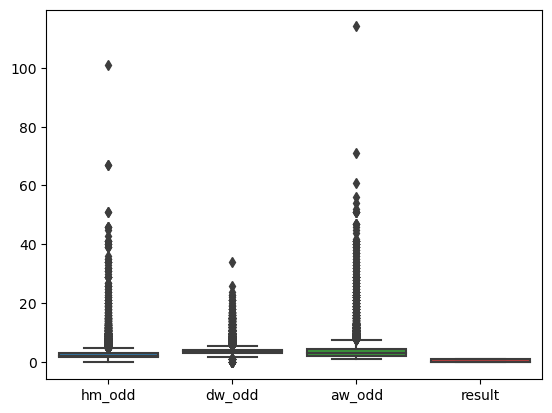

In [27]:
sns.boxplot(data=df)

__<h4>Removal of Outliers</h4>__

<AxesSubplot:>

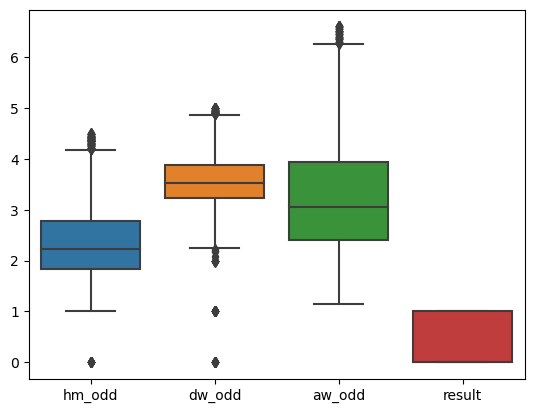

In [28]:
df.hm_odd=np.where(df.hm_odd>4.5,np.nan, df.hm_odd)
df.dw_odd=np.where(df.dw_odd>5,np.nan, df.dw_odd)
df.aw_odd=np.where(df.aw_odd>6.6,np.nan, df.aw_odd)
df2=df.dropna()
df=df2
sns.boxplot(data=df2)

In [29]:
df.result.value_counts()

0    3175
1    2578
Name: result, dtype: int64

__<h2>MODEL DEVELOPMENT</h2>__
__<h3>Determining the Best Model</h3>__

In [31]:
import lazypredict
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

X=df.drop('result', axis=1)
y=df['result']

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3, stratify=y)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [00:07<00:00,  3.90it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
CalibratedClassifierCV             0.63               0.61     0.61      0.62   
LinearDiscriminantAnalysis         0.63               0.61     0.61      0.62   
LinearSVC                          0.63               0.61     0.61      0.62   
RidgeClassifier                    0.63               0.61     0.61      0.62   
LogisticRegression                 0.63               0.61     0.61      0.62   
RidgeClassifierCV                  0.63               0.61     0.61      0.62   
NearestCentroid                    0.61               0.61     0.61      0.61   
GaussianNB                         0.62               0.61     0.61      0.62   
SVC                                0.62               0.61     0.61      0.61   
BernoulliNB                        0.61               0.60     0.60      0.61   
QuadraticDiscriminantAnalysi

__<h2>LOGISTIC REGRESSION</h2>__

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model_lr=LogisticRegression()

model_lr.fit(x_train,y_train)
y_pred=model_lr.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6251448435689455
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       953
           1       0.60      0.48      0.53       773

    accuracy                           0.63      1726
   macro avg       0.62      0.61      0.61      1726
weighted avg       0.62      0.63      0.62      1726



In [33]:
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=model_lr, X=x_train, y=y_train, cv=10, n_jobs=-1)
accuracies

array([0.61538462, 0.5955335 , 0.56575682, 0.57568238, 0.63771712,
       0.62779156, 0.64764268, 0.59701493, 0.60447761, 0.5920398 ])

__<h3>FINE TUNING THE MODEL</h3>__

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


param_grid = [    
    {'penalty' : [ 'l2', ],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)



In [ ]:
clf= GridSearchCV(model_lr, param_grid = param_grid, cv = 3, verbose=False,
                  n_jobs=-1,scoring='accuracy',error_score=0)


In [ ]:
best_clf = clf.fit(x_train,y_train)
best_clf.best_params_

In [ ]:
model_lr=LogisticRegression(penalty=best_clf.best_params_['penalty'],
                           C=best_clf.best_params_['C'],
                           max_iter=best_clf.best_params_['max_iter'],
                           solver=best_clf.best_params_['solver'])

In [ ]:
best_clf.best_params_['penalty']

In [ ]:
model_lr.fit(x_train,y_train)
y_pred=model_lr.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

__<h3>CONFUSION MATRIX</h3>__

In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)

[[710 243]
 [404 369]]


              precision    recall  f1-score   support

           0       0.64      0.75      0.69       953
           1       0.60      0.48      0.53       773

    accuracy                           0.63      1726
   macro avg       0.62      0.61      0.61      1726
weighted avg       0.62      0.63      0.62      1726



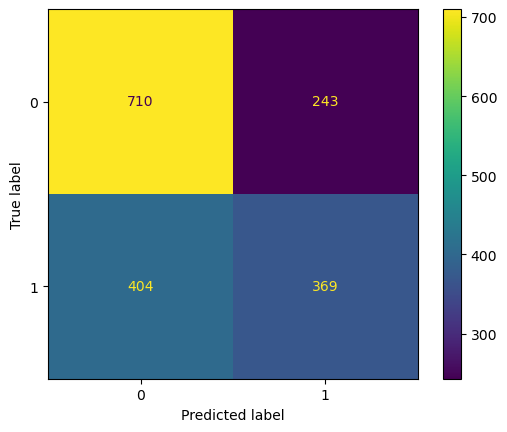

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def custom_confusion_matrix(y_test, y_pred, display_labels=None):

    """
    A function to plot a custom confusion matrix with
    x2 (away double chance) class as the first row and the first column.
    """
    # Create a  matrix
    cm = (confusion_matrix(y_test, y_pred))
    # Create the plot
    #fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(cm, display_labels=display_labels)

    cmp.plot()
    #cmp.plot(ax=ax)

custom_confusion_matrix(
  y_test, y_pred,display_labels=['0', '1'] 
  
)
print(classification_report(y_test,y_pred))

__<h3>Interpreting the confusion matrix using class 0 (the negative class)</h3>__
- Precision: Of all the negatives the model has predicted, how many of those are actually negative 
    - precision = TN/(TN+FN) = 582(582+328)= 0.64
- Recall: Of all existing negatives in the dataset, how many did the model correctly identify as negative    
    - recall= TN/(TN+FP) = 582(582+184)= 0.76

__<h3>TESTING  MODEL ON NEW DATA</h3>__

In [36]:
df3=pd.read_csv('/Users/ERIA/Desktop/test_data2.csv')
#df3.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df3.head()

,hm_odd,dw_odd,aw_odd,result
0,2.26,3.15,3.36,1
1,2.40,3.13,3.00,0
2,2.93,2.94,2.65,0
3,3.82,3.29,2.03,1


In [37]:
x_test2=df3.iloc[:,:3]
x_test2

,hm_odd,dw_odd,aw_odd
0,2.26,3.15,3.36
1,2.40,3.13,3.00
2,2.93,2.94,2.65
3,3.82,3.29,2.03


In [38]:
y_pred2=model_lr.predict(x_test2)
print('actual values   --->',list(np.array(df3.result)))
print('predicted values -->',list(np.array(y_pred2)))

actual values   ---> [1, 0, 0, 1]
predicted values --> [0, 0, 0, 0]
